In [1]:
import numpy as np
import pandas as pd

# Plotting code:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
import matplotlib.pyplot as plt

Text(0.5, 0, 'Time')

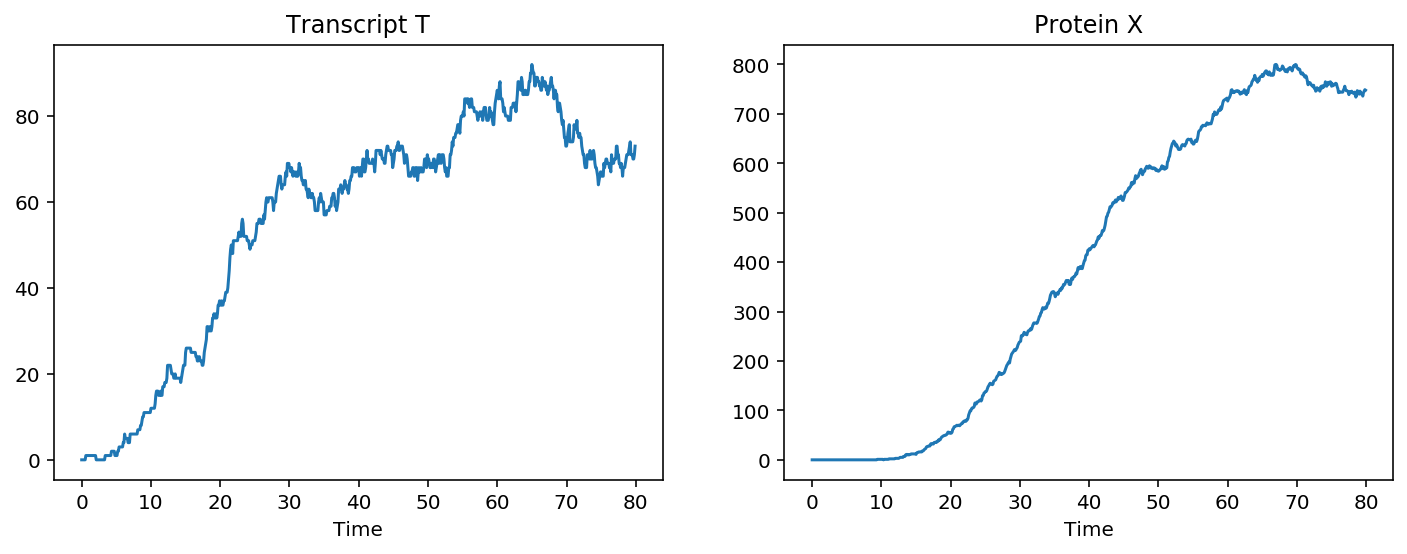

In [2]:
from bioscrape.simulator import py_simulate_model
from bioscrape.types import Model
#Create a list of species names (strings)
species = ["G", "T", "X", "I"]

#create a list of parameters in the form (param_name[string], param_val[number])
delay_tx = 10
delay_tl = 5
params = [("ktx", 15), ("ktl", 100.0), ("KI", 10), ("n", 2.0), ("KR", 20), 
          ("delta", .1), ("delay_tx", 10),("delay_tl", 5)]
#create reaction tuples with delays require additional elements. They are of the form:
#(Inputs[string list], Outputs[string list], propensity_type[string], propensity_dict {propensity_param:model_param},
# delay_type[string], DelayInputs [string list], DelayOutputs [string list], delay_param_dictionary {delay_param:model_param}).

rxn1d = (["G"], ["G"], "proportionalhillpositive", {"d":"G", "s1":"I", "k":"ktx", "K":"KI", "n":"n"},
       "gaussian", [], ["T"], {"mean":delay_tx, "std":5.0})
rxn2d = (["T"], ["T"], "hillpositive", {"s1":"T", "k":"ktl", "K":"KR", "n":1},
        "gamma", [], ["X"], {"k":delay_tl, "theta":3.0})
rxn3 = (["T"], [], "massaction", {"k":"delta"})
rxn4 = (["X"], [], "massaction", {"k":"delta"})
#Reactions 3 and 4 remain unchanged
rxns_delay = [rxn1d, rxn2d, rxn3, rxn4]
x0 = {"G":1, "I":10}

#Instaniate the Model object, species, params, and x0 remain unchanged from the previous example
M_delay = Model(species = species, parameters = params, reactions = rxns_delay, initial_condition_dict = x0)

#Simulate the Model with delay
timepoints = np.arange(0, 80, .1)
results_delay = py_simulate_model(timepoints, Model = M_delay, stochastic = True, delay = True)

#Plot the results
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.title("Transcript T")
plt.plot(timepoints, results_delay["T"])
plt.xlabel("Time")

plt.subplot(122)
plt.title("Protein X")
plt.plot(timepoints, results_delay["X"])
plt.xlabel("Time")

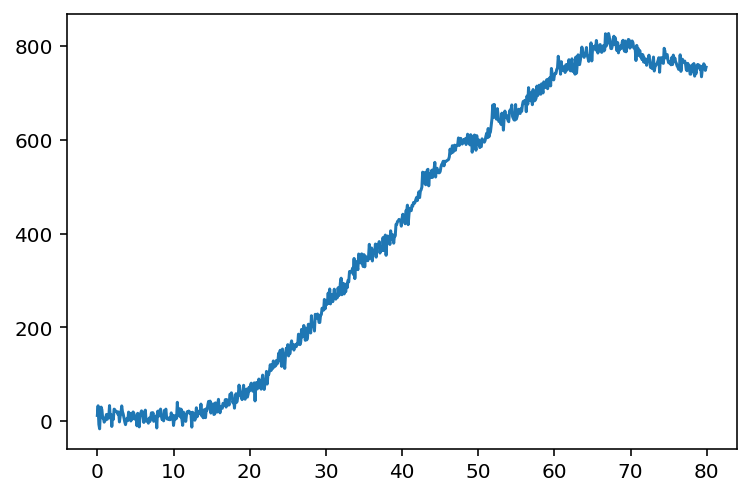

In [3]:
delay_data = pd.DataFrame()
delay_data['X'] = results_delay['X'] + np.random.normal(10, 10, size = np.shape(results_delay['X']))
delay_data['t'] = timepoints
plt.plot(delay_data['t'], delay_data['X'])

## Least squares fit using LMFit and Bioscrape

Successfully completed parameter identification procedure using LMFit. Parameter values and fitness reports written to lmfit_results.csv file. Check the minimizer_results object returned to further statistically evaluate the goodness of fit.


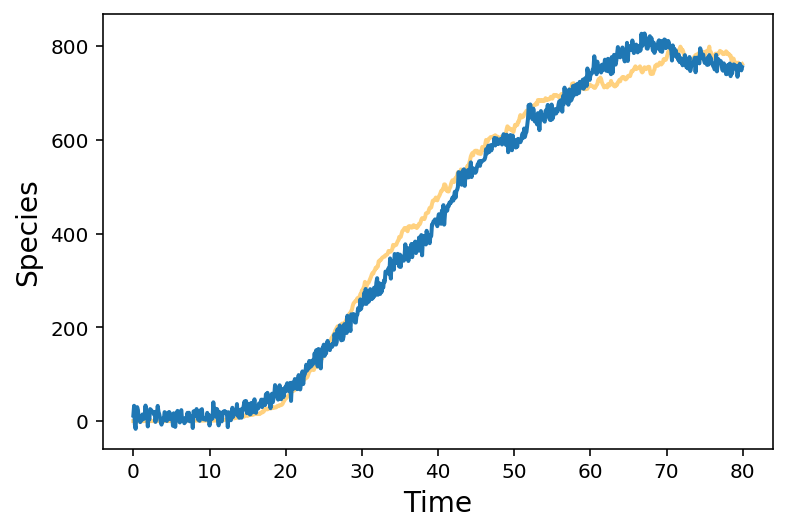

In [7]:
from bioscrape.inference import py_inference
# Create prior for parameters
prior = {'DummyVar_GaussianDelay_mean_0':['uniform', 0, 1000],'DummyVar_GammaDelay_k_3':['uniform', 0, 100],
         'delta':['uniform', 0, 5], 'ktx':['uniform', 0, 100], 'ktl':['uniform', 20, 1000],
         'KR':['uniform', 0, 100], 'KI':['uniform', 0, 100]}
minimizer_results = py_inference(Model = M_delay, exp_data = delay_data, measurements = ['X'], time_column = ['t'],
                                 params_to_estimate = ['DummyVar_GaussianDelay_mean_0','DummyVar_GammaDelay_k_3', 
                                                       'delta', 'ktx', 'ktl', 'KR','KI'], 
                                 prior = prior, plot_show = True, 
                                 sim_type = 'stochastic',
                                 inference_type = 'lmfit', method = 'leastsq')

## Note: The orange trajectories above are the model simulations and blue is the data. Check lmfit_results.csv for more information on parameter values and fitness reports.

In [24]:
minimizer_results[0]